# Open, Plot, and Explore Raster Data

## Open raster data

Each pixel value represents an area on the Earth's surface. A raster file is composed of regular grid of cells, all of which are the same size. Raster data can be used to store many different types of scientific data including:
- elevation data
- canopy height models
- surface temperature
- climate model data outputs
- LULC data
- and more

![raster-concept](raster-concept.png)

You will learn more about LIDAR derived raster data that represents both terrain/elevation data (electaion of the earth's surface), and surface elevation (elevation at the tops of trees, buildings etc. above the earth's surface).

![lidarTree-height](lidarTree-height.png)

* Data Tip: The data used in this lesson are NEON data.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

# GEt data and set work dir
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, "earth-analytics", "data"))

Below, you define the path to a lidar derived DEM that was created using NEON data

You then open the data using rio.open("path-to-raster-here")

In [2]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood", "spatial",
                           "boulder-leehill-rd", "pre-flood", "lidar",
                           "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

When you open raster data using rasterio you are creating a numpy array. Numpy is an efficient way to work with and process raster format data. You can plot your data using earthpy plot_bands() which takes a numpy array as an input and generates a plot.

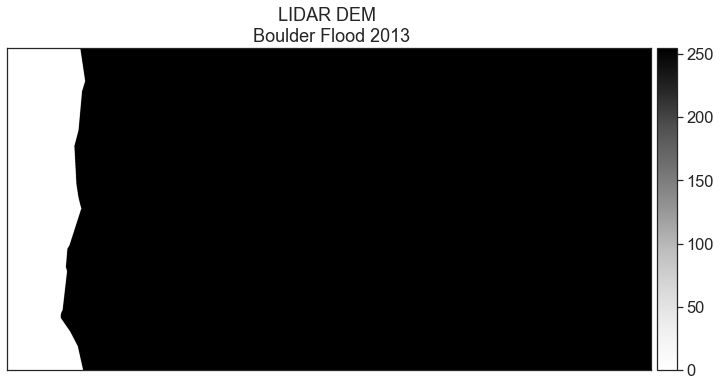

In [3]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
             title="LIDAR DEM \n Boulder Flood 2013",
             cmap="Greys")

plt.show()

The data above should represent terrain mnodel data. However, the range of values is not what is expected. THese data are for Boulder, Colorado where the elevation may range 1000-3000m

There may be some outlier values in the data that may need to be addressed.

In [4]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum rastesr value is: ", dtm_pre_arr.max())

the minimum raster value is:  -3.4028235e+38
the maximum rastesr value is:  2087.43


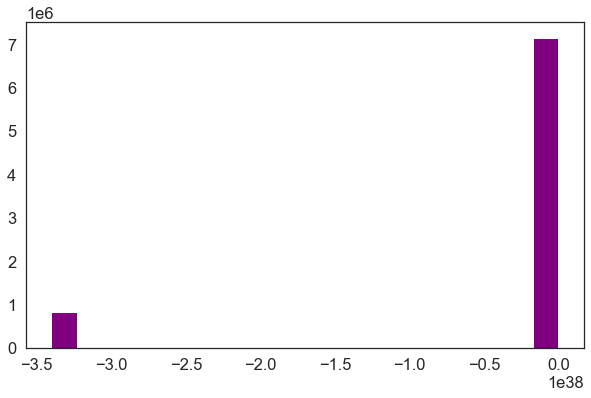

In [6]:
# A histogram can also be helpful to look at the range of values in your data
ep.hist(dtm_pre_arr,
       figsize=(10, 6))
plt.show()

## Raster data exploration - min and max values

Lookihng at the min value of the data, there is 1 of 2 things going on that need to be fixed
1. There may be no data values in the data with a negative value that are skewing your plot colours
2. There also could be outlier data in your raster

You can explore the 1st option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, you will use the masked=True parameter for the .read() funciton - like this:

dem_src.read(1, masked=True)

In [7]:
# Read in your data and mask the no data values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all no data values
    dtm_pre_arr = dem_src.read(1, masked=True)

Notice that now the min value looks more like an elevation value (which should most often not be negative).

In [8]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

the minimum raster value is:  1676.21
the maximum raster value is:  2087.43


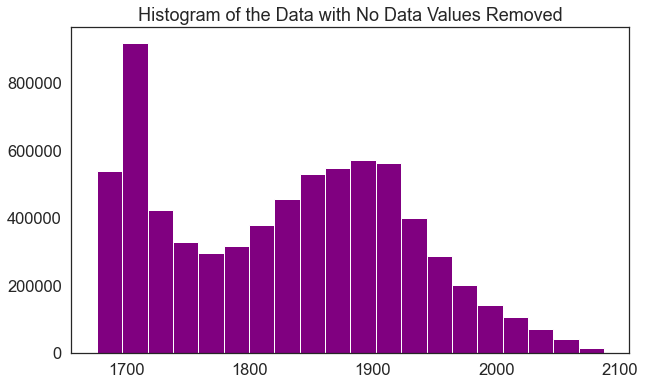

In [9]:
# A histogram can also be helpful to look at the range of values in your data
ep.hist(dtm_pre_arr,
       figsize=(10, 6),
       title="Histogram of the Data with No Data Values Removed")

plt.show()

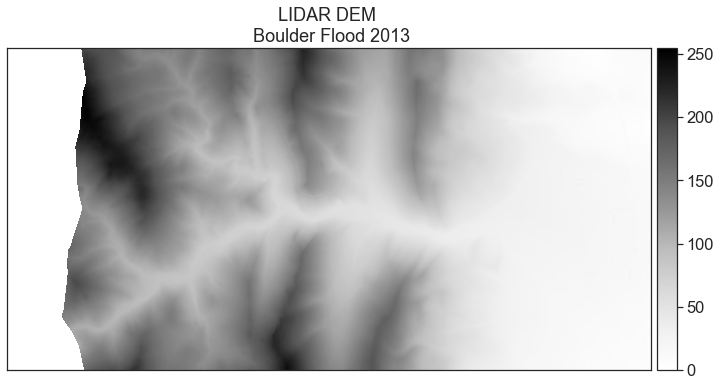

In [12]:
# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
             title="LIDAR DEM \n Boulder Flood 2013",
             cmap="Greys")

plt.show()

## Rasterio reads files into python as numpy arrays

When you call src.read() above, rasterio is reading in the data as numpy array. A numpy array is a matrix oc values. Numpy asrrays are an efficient structure for working with large and potentially multi-dim (layered) matrices.

The numpy array below is type numpy.ma.core.MaskedArray. It is a masked array because you chose to mask the no data values in your data. Masking ensures that when you plot and perform other math operations on your data, those no data values are not included in the operations

In [13]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    
print("Numpy Array Shape: ", lidar_dem_im.shape)
print("Object type: ", type(lidar_dem_im))

Numpy Array Shape:  (2000, 4000)
Object type:  <class 'numpy.ma.core.MaskedArray'>


A numpy array does not by default store spatial info. However, your raster data is spatial - it represents a location on the earth's surface.

You can access the spatial metadata within the context manager using demn_src.profile. Notice that the .profile object contains information including the no data values for your data, the shape, the file type and even the CRS.

In [14]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    lidar_dem_meta = dem_src.profile
    
lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

## Context managers to open and close file connections

The steps above represent the steps you need to open and plot raster dataset using rasterio in python. THe with rio.open() statement creates what is known as a context manager. A context manager allows you to open the data and work with it. Within the context manager, Python makes a temporary connection to the file that you are trying to open.

In the example above this was a file called pre_DTM.tif.

To break this code down, the context manager has a few parts. 1st, it has a with statement. THe with statement creates a connection to the file that you want to open. The default connection type is read only. This means that you can NOT modify that file by default. Not being able to modify the original data is a good thing because it prevents you from making unintended changes to your original data.

with rio.open("file-path-here") as file_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
    
Notice that the 1st line of the context manager is not indented. It contains 2 parts:
1. rio.open(): This is the code that will open a connection to your .tif file using a path you provide.
2. file_src_: this is a rasterio reader object that you can use to read in the actual data. You can also use this object to access the metadata for the raster file.

The 2nd line of your with statement

dtm_pre_arr = dem_src.read(1, masked=True)

is idented. Any code that is indented directly below the with statement will become a part of the context manager. This code has direct access to the file_src object which is you recall above is the rasterio reader object.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory.

Once you are done opening and reading the data, the context manager closes that connection to the file. This efficiently ensures that the file won't be modified later in your code.

* Data Tip: You can open and close files without a context manager using the syntax below. The approach however is generally not recommended

In [15]:
lidar_dem = rio.open(dem_pre_path)
lidar_dem.close()

In [16]:
# Notice here the src object is printed and returns an "open" DatasetReader object
with rio.open(dem_pre_path) as src:
    print(src)

<open DatasetReader name='colorado-flood\spatial\boulder-leehill-rd\pre-flood\lidar\pre_DTM.tif' mode='r'>


In [17]:
# Note that the src object is nhow closed because it's not within the indented
# Part of the context manager above
print(src)

<closed DatasetReader name='colorado-flood\spatial\boulder-leehill-rd\pre-flood\lidar\pre_DTM.tif' mode='r'>


## Plot raster and vector data together: plot extents

Numpy arrays are an efficient way to store and process data. However, by default do not contain spatial info. To plot raster and vector data together on a map, you will need to create an extent object that defines the spatial extent of your raster layer. This will then allow you to plot a raster and vector data together to create a map.

Below you open a single shapefile that contains a boundary layer that you can overlay on top of your raster dataset.

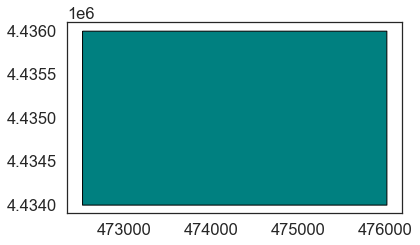

In [18]:
# Open site boundary vector layer
site_bound_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
site_bound_shp.plot(color="teal",
                   edgecolor="black")

plt.show()

You can try to plot the 2 datasets together but you will see below that the output plot does not look correct. This is because the raster layer has no spatial info associated with it.

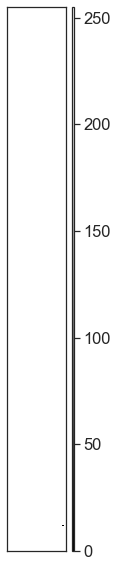

In [20]:
fig, ax = plt.subplots(figsize=(4, 10))

ep.plot_bands(dtm_pre_arr, ax=ax)

site_bound_shp.plot(color="teal",
                   edgecolor="black", ax=ax)

plt.show()

In [21]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an oboject called lidar_dem_meta that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)
    
# This plotting extent object will be used below to ensure your data overlay correctly
lidar_dem_plot_ext

(472000.0, 476000.0, 4434000.0, 4436000.0)

Next try to plot. This time however, use the extent= parameter to specify the plotting extent within ep.plot_bands()

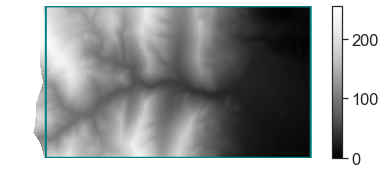

In [22]:
fig, ax = plt.subplots()

ep.plot_bands(dtm_pre_arr,
             ax=ax,
             extent=lidar_dem_plot_ext)

site_bound_shp.plot(color="None",
                   edgecolor="teal",
                   linewidth=2,
                   ax=ax)

# Turn off the outline or axis border on your plot
ax.axis("off")
plt.show()

* Data Tip: Customising Raster Plot Color Ramps to change the colour of a raster plot you set the colourmap. Matplotlib has a list of pre-determined colour ramps that you can choose from. You can reverse a colour ramp by adding _r at the end of the colour ramp's name. for example
cmap = "viridis"
vs
cmap = "viridis_r".